## Density estimation using Gaussian Processes and Poisson uncertainties with GPy

In [1]:
# Import libreraies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import GPy

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

Import data using Pandas

In [2]:
data=pd.read_csv('/Users/andreassolders/Box Sync/AlFONS_shared/Measurments/Measurement_IGISOL_2019/Homogenity/homo_sel.csv')
data['hit']=np.ones(len(data.index))
data.head()

,x_pos_d,y_pos_d,angle,radius,hit
0,-0.8250,-0.5280,290.560415,1.534761,1.0
1,1.6170,0.0495,343.916350,3.102435,1.0
2,-4.8015,2.1120,160.711810,3.641925,1.0
3,-0.7425,5.6760,82.571932,4.807343,1.0
4,4.7025,1.6500,6.963966,6.111588,1.0


Plot the data using matplotlib.

(-25, 25)

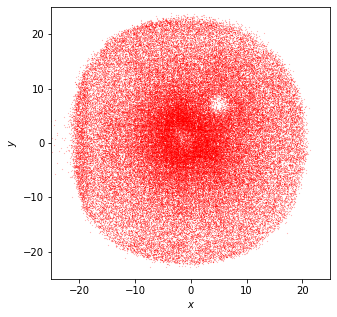

In [3]:
# Plot the data
plt.figure(figsize=[5,5])
plt.plot(data.x_pos_d, data.y_pos_d, 'r.', markersize=0.2, label='hits')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-25, 25)
plt.xlim(-25, 25)

Make a histogram of the data in x with bin position at the center of the bins.\
How does the bin size affect the final uncertainty?

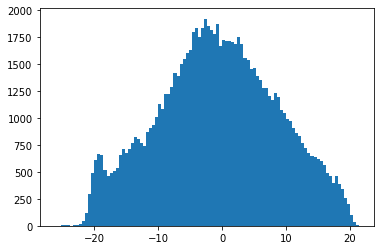

In [73]:
# Histogram data

data2=data[(data.y_pos_d<10.5) & (data.y_pos_d>9.5)]

z, bins = np.histogram(data.x_pos_d, bins=100)

width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, z, align='center', width=width)
plt.show()


Use Gaussian process to fit the histogram.\
Set the bin centers as X and the bin heights at Y\
Construct a kernel. Radial Basis Function (RBF) is the Gaussian kernel.\
$k(\sigma,r) = \sigma^2 e^{-\frac{1}{2}r^2}$\
The variance ($\sigma$) defines the maximum variation beteen neighbouring points.\
The lengthscale ($r$) defines how far appart points are correlated.

In [74]:
X = np.atleast_2d(center).T
Y = np.atleast_2d(z).T
#X = np.random.uniform(-3.,3.,(20,1))
#Y = np.sin(X) + np.random.randn(20,1)*0.05
#print(X)
kernel = GPy.kern.RBF(input_dim=1, variance=15, lengthscale=3)
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

m = GPy.core.GP(X,Y,likelihood=poisson_likelihood, inference_method=laplace_inf, kernel=kernel)
print(m)


Name : gp
Objective : 574.2759193238412
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |   15.0  |      +ve      |        
  rbf.lengthscale  |    3.0  |      +ve      |        


Plot the result

{'gpmean': [[<matplotlib.lines.Line2D at 0x1a2ebeffd0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1a2ebc8a50>]}

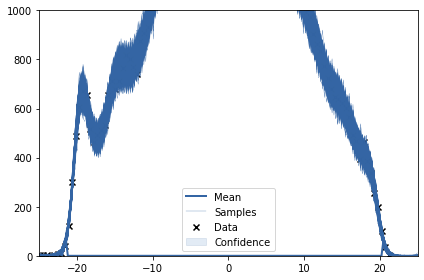

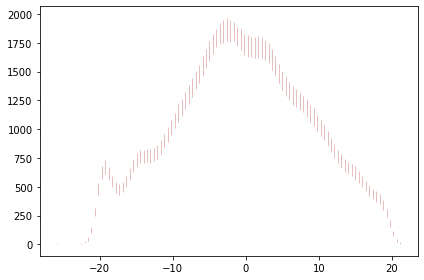

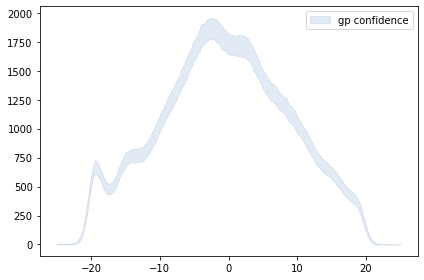

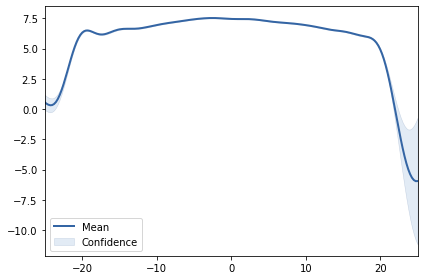

In [76]:
#GPy.plotting.change_plotting_library('plotly')
#m.optimize()
m.plot(plot_limits=[-25,25], samples=3000)
plt.ylim(bottom=0, top = 1000)
m.plot_errorbars_trainset()#plot()
m.plot_confidence(plot_limits=[-25,25])
#plt.ylim(bottom=0, top = 400)
m.plot_f(plot_limits=[-25,25])
#GPy.plotting.show(fig)

The ploting of the mean does not work. Something seem to be wrong in the conversion from log(m) to m.


Evaluate the model and plot the prediction with uncertainties.\
However, uncertainties are very small (~1).

 /Users/andreassolders/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:overflow encountered in exp


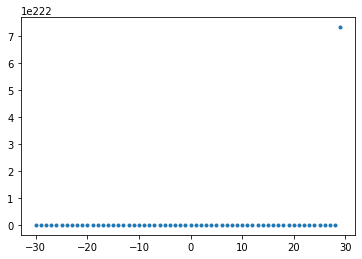

In [77]:
x = np.linspace(-30,30,61)[:,None]
#print(x)
logY_p, logVar_p  = m.predict(x)
#print(Var_p[:,0])

plt.figure(1)
#plt.ylim(bottom=-10, top = 6)
plt.plot(x,np.exp(logY_p),ls='None', marker='.')
#plt.errorbar(x,np.exp(logY_p),yerr=np.sqrt(logVar_p)[:,0],ls='None', marker='.')
#plt.figure(2)
#plt.plot(x, np.sqrt(Var_p)[:,0])
#print(logY_p)

Optimze the model parameters. By deafult, GPy uses the lbfgsb optimizer. The prefered optimizer is the scaled conjugate gradient (scg) method.\
The optimize_restarts function selects random initializations (drawn from N(0,1)) for the parameter values, optimizes each, and sets the model to the best solution found.

In [78]:
m.optimize_restarts(num_restarts = 10)
#m.optimize_restarts(optimizer='scg', num_restarts = 10)
print(m)

Optimization restart 1/10, f = 573.1012971496559
Optimization restart 2/10, f = 573.1015409648771
Optimization restart 3/10, f = 573.1015707521199
Optimization restart 4/10, f = 573.1014345294251
Optimization restart 5/10, f = 573.1015502584312
Optimization restart 6/10, f = 573.1014360195785
Optimization restart 7/10, f = 573.101663576153
Optimization restart 8/10, f = 573.1013094987185
Optimization restart 9/10, f = 573.1014169844613
Optimization restart 10/10, f = 573.1016311459307

Name : gp
Objective : 573.1012971496559
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |              value  |  constraints  |  priors
  rbf.variance     |  26.57480349587484  |      +ve      |        
  rbf.lengthscale  |  3.165383610769988  |      +ve      |        


The Gaussin_noice.variance is the variance of the original datapoints assuming Gaussian uncertainties.

Plot the result with uncertainties

(0, 2000)

<Figure size 432x288 with 0 Axes>

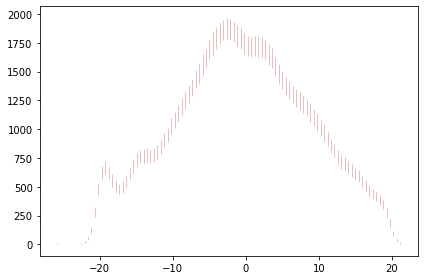

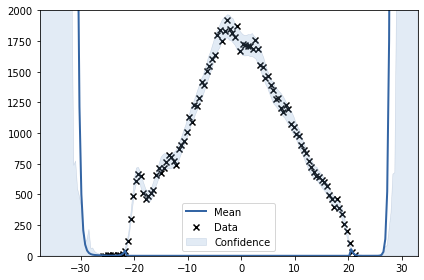

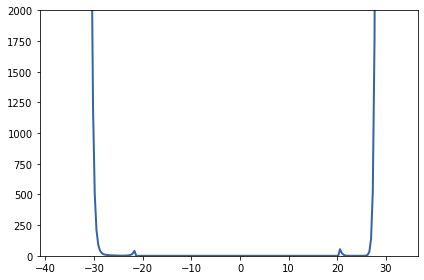

In [80]:
plt.figure(1)
fig = m.plot_errorbars_trainset()#m.plot()#plot_density=True)
plt.figure(2)
m.plot()#plot_density=True)
plt.ylim(bottom=0, top = 2000)
plt.figure(3)
fig = m.plot_mean()#plot_density=True)
plt.ylim(bottom=0, top = 2000)
#plt.ylim(bottom=-100, top = 500)
#GPy.plotting.show(fig)


Normal ploting still does not work.


Evaluate and plot.\

1731.4958678840067
41.61124689172396
0.02403196430527751
41.46867065477886
0.023949621494307176
1.0120465062232484


(-10, 2000)

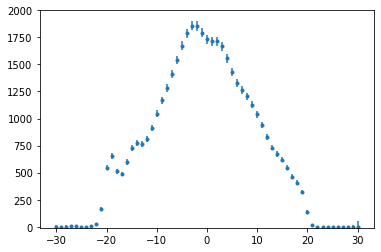

In [83]:
x = np.linspace(-30,30,61)[:,None]
#print(x)
logY_p, logVar_p = m._raw_predict(x)
Y_p = np.exp(logY_p)
sig_p = np.exp(logY_p+np.sqrt(logVar_p))-np.exp(logY_p-np.sqrt(logVar_p))
print((Y_p)[30,0])
print(np.sqrt(Y_p)[30,0])
print(1/np.sqrt(Y_p)[30,0])
print(sig_p[30,0])
print(sig_p[30,0]/Y_p[30,0])
print(np.exp(np.sqrt(logVar_p[30,0])))
plt.errorbar(x,Y_p,yerr=sig_p[:,0], fmt='none')
plt.scatter(x,Y_p, marker='.')
plt.ylim(bottom=-10, top = 2000)

(-10, 2000)

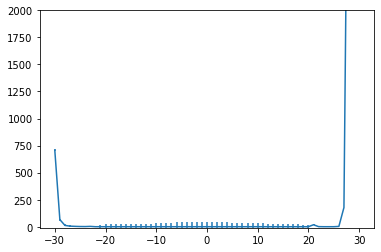

In [96]:
#x = np.linspace(-30,30,61)[:,None]
#print(x)
Y_pred, Var_pred = m.predict(x)#, include_likelihood=False)
plt.errorbar(x,Y_pred, yerr=sig_p[:,0])#marker='.')
plt.ylim(bottom=-10, top = 2000)

In [ ]:
conf = 1.

plt.fill_between(x[:,0], np.exp(logY_p+conf*np.sqrt(logVar_p))[:,0], np.exp(logY_p-conf*np.sqrt(logVar_p))[:,0])
plt.ylim(bottom=-100, top = 1000)

Create 2D histogram and find the center of the bins.

In [ ]:
# 2D Histogram data in (x,y)
plt.figure(figsize=[6,5])

histdata, xbins, ybins = np.histogram2d(data.x_pos_d, data.y_pos_d, bins=60)

xwidth = 1 * (xbins[1] - xbins[0])
ywidth = 1 * (ybins[1] - ybins[0])
xcenter = (xbins[:-1] + xbins[1:]) / 2
ycenter = (ybins[:-1] + ybins[1:]) / 2

#plt.contourf(xcenter, ycenter, histdata)
#plt.colorbar()
#plt.show()

#print(histdata)

In [ ]:
plt.figure(figsize=[6,5])
plt.pcolormesh(xbins,ybins,histdata)
plt.colorbar()
plt.show()

Prepare the arrays.\
Create the kernal.\
Create a gaussian process.\
Optimize and print\

In [ ]:
#XY = np.array([xcenter,ycenter]).T

XX, YY = np.meshgrid(xcenter, ycenter)
XF=XX.flatten()
YF=YY.flatten('C')
XY = np.array([XF,YF]).T

Z=np.atleast_2d(histdata.flatten()).T

# define kernel
kernel2 = GPy.kern.RBF(input_dim=2, variance=100, lengthscale=1)

# create simple GP model
m2 = GPy.models.GPRegression(XY,Z,kernel2)

# optimize and display (By deafult, GPy uses the lbfgsb optimizer.)
m2.optimize_restarts(num_restarts = 10)
display(m2)

In [ ]:
#print(m2)
#GPy.plotting.change_plotting_library('matplotlib')
m2.plot()
#fig = m2.plot()
#display(GPy.plotting.show(fig))
#display(GPy.plotting.show(fig))
#plt.show()
#GPy.plotting.show(fig)

Evaluate the model at possitions x_p and y_p.\
(This was my solution, a better and faster way I found online follows.)

In [ ]:
x_p = np.linspace(-25.7395875,21.0370875,240)#[:,None]
y_p = np.linspace(-22.4467375,23.4862375,240)#[:,None]
#xy_p =np.array([x_p,y_p]).T

Z_p = np.zeros(shape=(len(x_p),len(y_p)))
VarZ_p = np.zeros(shape=(len(x_p),len(y_p)))

for i in range(len(x_p)):
    for j in range(len(y_p)):
        Z_p[i,j], VarZ_p[i,j]  = m2.predict(np.atleast_2d([x_p[i],y_p[j]]))#[x_p[i],y_p[j]]))
        #Z_out = np.append(Z_out,Z_p)
        
#Z_p, VarZ_p  = m2.predict(XY)
#Z_p, VarZ_p  = m2.predict(np.atleast_2d([0,1]))

Plot the result as contour plot

In [ ]:
plt.figure(figsize=[5,5])

#Axes3D.scatter(XY[:,0], XY[:,1], Z_p[:,0])
#plt.scatter(XY[:,0],Z_p)
plt.contourf(x_p, y_p, Z_p)
#plt.contourf(XY[:,0], XY[:,1], Z_p)

Plot the result as mesh plot.

In [ ]:
plt.figure(figsize=[6,5])

plt.pcolormesh(x_p, y_p, Z_p)
plt.colorbar()

This is a better and faster way of evaluating the solution. The resolution can be set by res.

In [ ]:
res = 240
xi, yi = np.mgrid[min(xbins):max(xbins):res*1j, min(ybins):max(ybins):res*1j]
Z_p, VarZ_p  = m2.predict(np.vstack([xi.flatten(), yi.flatten()]).T)
zi = Z_p.reshape(xi.shape)

However, ploting the result we note that the x and y axis have changed place. Compare with plot of data.

In [ ]:
plt.figure(figsize=[6,5])

plt.pcolormesh(xi, yi, zi)
plt.colorbar()